# Liveness detection

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import face_recognition as fr
import dlib
import numpy as np
from scipy.spatial import distance as dist
from emoji import emojize, emoji_list
from tensorflow.keras.models import load_model

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## OpenCV Haar-Cascade Smile detection

In [6]:
smile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_smile.xml')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

In [7]:
def detect(frame):
    resultImg = frame.copy()
    gray  = cv2.cvtColor(resultImg, cv2.COLOR_BGR2GRAY) 
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3,
            minNeighbors=2)
    for (x, y, w, h) in faces:
        cv2.rectangle(resultImg, (x, y), ((x + w), (y + h)), (255, 0, 0), 2)
        face_gray = gray[y:y + h, x:x + w]
        face_color = resultImg[y:y + h, x:x + w]
        smiles = smile_cascade.detectMultiScale(face_gray, scaleFactor=1.8,
                                                minNeighbors=20)
        smile_text ='No smile' if smiles==[] or smiles==() else 'Smile'        
        cv2.putText(resultImg, f'{smile_text}', (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)   
        return resultImg
        #for (sx, sy, sw, sh) in smiles:
        #    cv2.rectangle(face_color, (sx, sy), ((sx + sw), (sy + sh)), (0, 0, 255), 2)    

C:\Users\elinam\.conda\envs\nlp_cv\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if sys.path[0] == "":


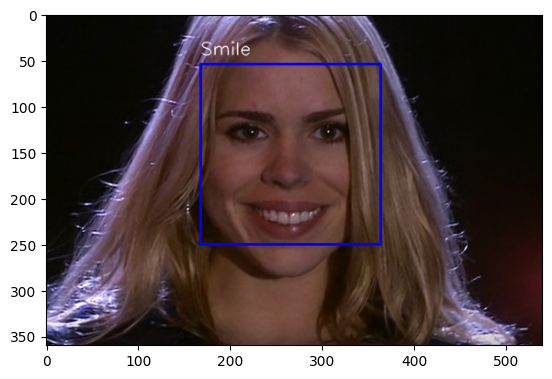

In [8]:
plt.imshow(cv2.cvtColor(detect(cv2.imread("data/rose_1.jpg")),cv2.COLOR_BGR2RGB))

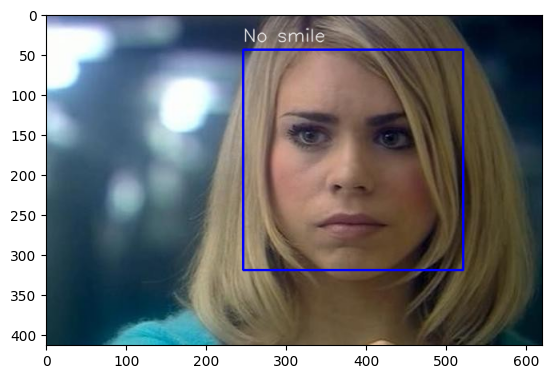

In [9]:
plt.imshow(cv2.cvtColor(detect(cv2.imread("data/rose_2.jpg")),cv2.COLOR_BGR2RGB))

## Dlib smile detection and blink detection via landmarks

In [10]:
im = cv2.imread("data/rose_1.jpg")
landmarks = fr.face_landmarks(im)
print(landmarks)

[{'chin': [(168, 130), (169, 154), (170, 178), (173, 203), (182, 226), (198, 246), (217, 265), (238, 280), (262, 286), (285, 280), (304, 264), (321, 245), (334, 224), (342, 202), (346, 178), (347, 156), (347, 133)], 'left_eyebrow': [(186, 113), (199, 105), (216, 104), (232, 106), (248, 113)], 'right_eyebrow': [(281, 112), (296, 106), (311, 103), (327, 104), (339, 112)], 'nose_bridge': [(264, 129), (264, 145), (264, 160), (264, 176)], 'nose_tip': [(245, 185), (254, 188), (264, 191), (273, 188), (281, 185)], 'left_eye': [(204, 130), (215, 123), (229, 124), (239, 134), (227, 136), (214, 136)], 'right_eye': [(288, 134), (299, 124), (313, 123), (323, 131), (314, 136), (301, 137)], 'top_lip': [(216, 208), (234, 206), (253, 206), (264, 208), (275, 206), (292, 207), (308, 209), (302, 212), (275, 214), (264, 215), (253, 213), (222, 210)], 'bottom_lip': [(308, 209), (293, 233), (276, 243), (263, 245), (251, 243), (232, 233), (216, 208), (222, 210), (252, 231), (264, 233), (275, 231), (302, 212)]

In [11]:
def render_landmarks(im, landmarks):    
    for face in landmarks:   
        for key in face.keys():
            for point in face[key]:
                cv2.circle(im, (int(point[0]),int(point[1])), 2, (255,0,0),-1)      

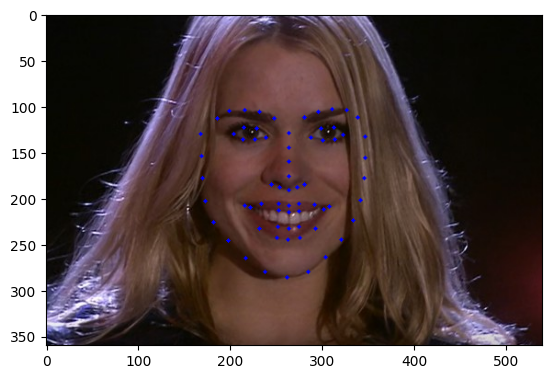

In [12]:
from itertools import chain
# Read an image to a variable
im = cv2.imread("data/rose_1.jpg")
landmarks = fr.face_landmarks(im)
render_landmarks(im, landmarks)
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

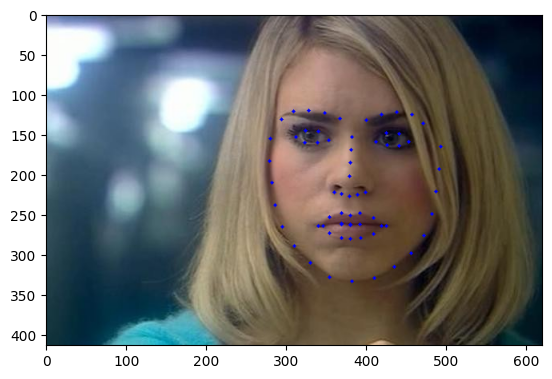

In [13]:
from itertools import chain
# Read an image to a variable
im = cv2.imread("data/rose_2.jpg")
landmarks = fr.face_landmarks(im)
render_landmarks(im, landmarks)
plt.imshow(cv2.cvtColor(im,cv2.COLOR_BGR2RGB))

The function below calculates the smiling score based on this post

https://medium.com/decathlontechnology/smile-detection-for-image-moderation-9b06b695f642

In [14]:
def is_smile(face,landmarks):    
    # Calculate the lips width    
    left_lip_edge = np.array(landmarks['top_lip'][0])
    right_lip_edge = np.array(landmarks['top_lip'][6])
    lips_width = np.abs(left_lip_edge[0]-right_lip_edge[0])    
    face_width = np.abs(landmarks['chin'][2][0] - landmarks['chin'][14][0])   
    return  lips_width/face_width >=0.5   

In [15]:
def find_bounding_coordinates_from_landmarks(landmarks):
    #find min y for face bounding box
    min_y = 1000000
    min_x = 1000000
        
    for (x,y) in landmarks['right_eyebrow']:
        if y< min_y:
            min_y=y
                
    for (x,y) in landmarks['left_eyebrow']:
        if y< min_y:
            min_y=y        
        
    #find the rest coordinates
    max_y = -1
    max_x = -1   
        
    for (x,y) in landmarks['chin']:
        if x < min_x:
            min_x=x
        if x > max_x:
            max_x=x    
        if y > max_y:
            max_y=y 
    return(min_x,min_y,max_x,max_y)   

In [16]:
def fr_smile_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy()
    smiles = []
    for landmarks in landmarks_collection:        
        smiled = is_smile(resultImg,landmarks)
        smile_text='No smile' if not smiled else "Smile"            
        smiles.append(smiled)
        if display:        
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks)    
                
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{smile_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg,smiles

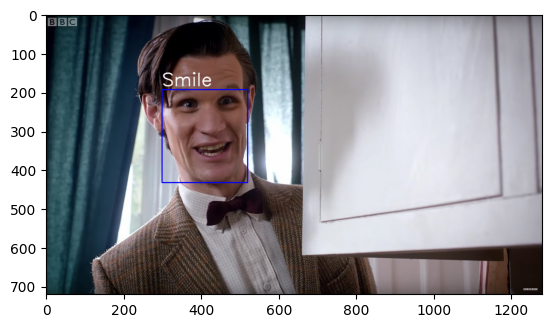

In [17]:
img = cv2.imread("data/dw_11_happy.jpg")
#detector = dlib.get_frontal_face_detector()
landmarks_collection = fr.face_landmarks(img) 
result,params = fr_smile_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

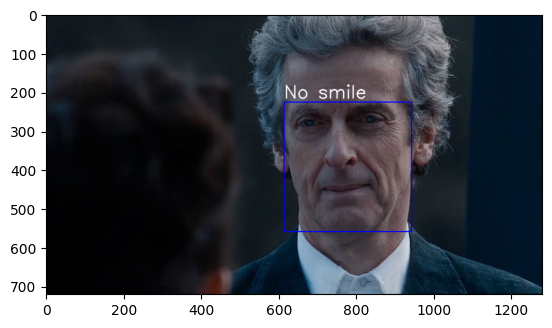

In [18]:
img = cv2.imread("data/capaldi.jpg")
#detector = dlib.get_frontal_face_detector()
landmarks_collection = fr.face_landmarks(img) 
result,_ = fr_smile_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

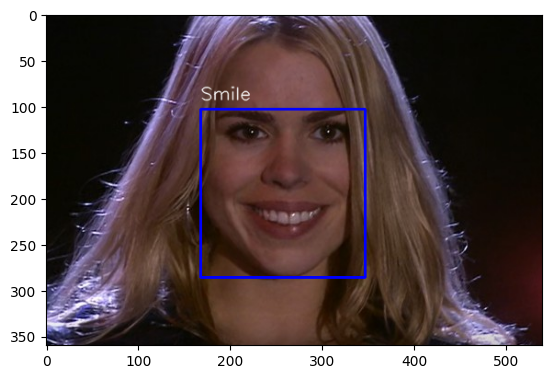

In [19]:
img = cv2.imread("data/rose_1.jpg")
landmarks_collection = fr.face_landmarks(img) 
result,_ = fr_smile_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

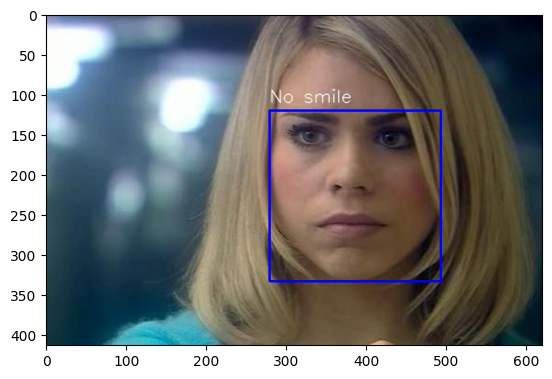

In [20]:
img = cv2.imread("data/rose_2.jpg")
landmarks_collection = fr.face_landmarks(img) 
result,_ = fr_smile_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

In [21]:
def get_ear(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dist.euclidean(eye[0], eye[3]) 
    # compute the eye aspect ratio
    ear = (A + B) / (2.0 * C) 
    # return the eye aspect ratio
    return ear


In [22]:
def fr_blink_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy()       
    eyes_opened_closed = []
    for landmarks in landmarks_collection:
        left_eye = landmarks['left_eye']
        right_eye = landmarks['right_eye']
        ear_right = get_ear(right_eye)
        ear_left = get_ear(left_eye)    
                       
        eyes_closed =  ear_right < 0.16 and ear_left < 0.16
        #print(ear_left,ear_right)
        eyes_opened_closed.append(eyes_closed)
        if display:
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks)            
            eyes_text = "Eyes are closed" if eyes_closed else "Eyes are opened"        
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{eyes_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg,eyes_opened_closed

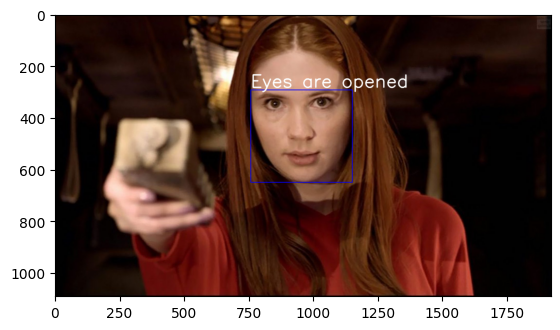

In [23]:
img = cv2.imread("data/amy_opened_eyes.jpg")
landmarks_collection = fr.face_landmarks(img)
result,_ = fr_blink_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

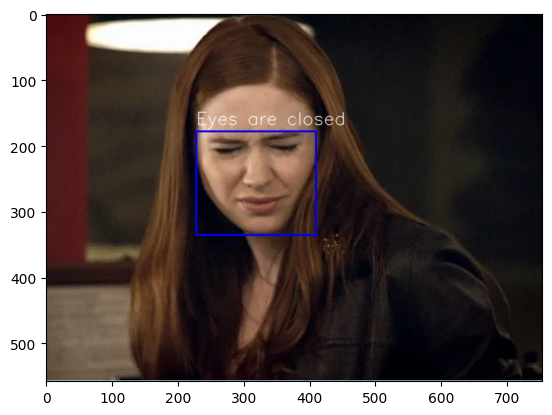

In [24]:
img = cv2.imread("data/amy_closed_eyes.png")
landmarks_collection = fr.face_landmarks(img)
result,_ = fr_blink_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

## Eyes roll detection with deap learning abd face_recognition

In [25]:
lmodel = load_model('data/left_eye.h5')
rmodel = load_model('data/right_eye.h5')

In [26]:
def get_eyes(frame, landmarks):
    x1,y1 = landmarks['left_eye'][0][0], landmarks['left_eye'][1][1]
    x2,y2 = landmarks['left_eye'][3][0], landmarks['left_eye'][5][1]
    shape1 = [(x1-5,y1-5), (x2+5,y2+5)]
        
    x11,y11 = landmarks['right_eye'][0][0], landmarks['right_eye'][1][1]
    x21,y21 = landmarks['right_eye'][3][0], landmarks['right_eye'][5][1]
    shape2 = [(x11-5,y11-5), (x21+5,y21+5)]
        
    left_eye = frame[shape1[0][1]:shape1[1][1],shape1[0][0]:shape1[1][0],:]
    right_eye = frame[shape2[0][1]:shape2[1][1],shape2[0][0]:shape2[1][0],:]
    return (left_eye, right_eye)

In [27]:
def fr_dnn_eye_roll_detect(frame,landmarks_collection,display=True):        
    resultImg=frame.copy() 
    eyes_rolled=[]
    for landmarks in landmarks_collection:
        
       #detecting the boundaries of both eyes
        
        left_eye, right_eye = get_eyes(frame,landmarks)
        l_img =  cv2.resize(left_eye, (30,20), interpolation = cv2.INTER_AREA)        
        x = np.expand_dims(l_img, axis=0)
        images = np.vstack([x])       
        l_prediction = lmodel.predict(images, batch_size=10)    
        
        r_img =  cv2.resize(right_eye, (30,20), interpolation = cv2.INTER_AREA)        
        x = np.expand_dims(r_img, axis=0)
        images = np.vstack([x])       
        r_prediction = rmodel.predict(images, batch_size=10)       
                
        eyes_rolled_flag =  l_prediction[0] >=0.5 and r_prediction[0] >=0.5
        eyes_text = "Eyes are rolled" if eyes_rolled_flag else "Eyes are not rolled"
        eyes_rolled.append(eyes_rolled_flag)
        if(display):
            (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks) 
            cv2.rectangle(resultImg, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
            cv2.putText(resultImg, f'{eyes_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*resultImg.shape[1],
                    (255,255,255), int(0.002*resultImg.shape[1]), cv2.LINE_AA)       
        
    return resultImg, eyes_rolled

1/1 [==============================] - 0s 135ms/step


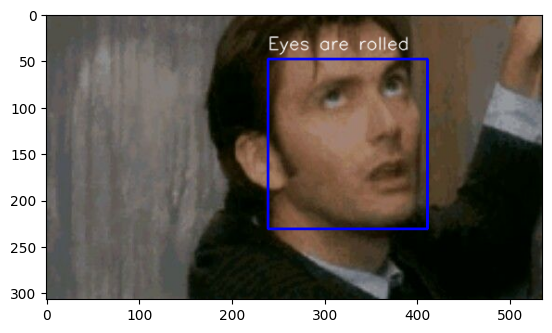

In [28]:
img = cv2.imread("data/dw10_rolleyes.jpg")
landmarks_collection = fr.face_landmarks(img)
result,_ = fr_dnn_eye_roll_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

1/1 [==============================] - 0s 31ms/step


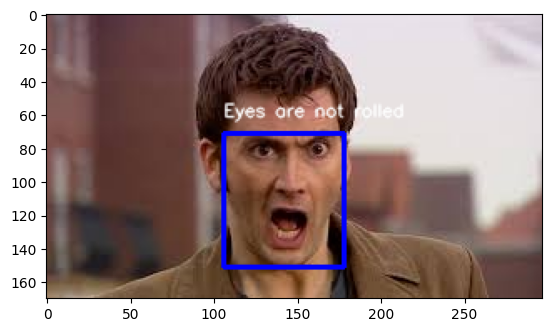

In [29]:
img = cv2.imread("data/dw_10_1.jpg")
landmarks_collection = fr.face_landmarks(img)
result,_ = fr_dnn_eye_roll_detect(img,landmarks_collection)
plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))

## Liveness detection on live stream

### Smile detection (Haar-cascade)

In [30]:
video_capture = cv2.VideoCapture(0)
previous_state=-1
state=-1
smile_counter=0
while video_capture.isOpened():
   # Captures video_capture frame by frame
    _, frame = video_capture.read() 
    # To capture image in monochrome                    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)       
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces)>0:
        #assume we have only one face
        (x,y,w,h) = faces[0]    
        cv2.rectangle(frame, (x, y), ((x + w), (y + h)), (255, 0, 0), 2)
        gray_face = gray[y:y + h, x:x + w]
        color_face = frame[y:y + h, x:x + w]
        smiles = smile_cascade.detectMultiScale(gray_face, 1.8, 20)
        state = 1 if len(smiles)>0 else 0
        if state==1 and state!=previous_state:
            cv2.putText(frame, 'smiled!!!', (x, y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0006*img.shape[1],
                    (255,255,255), int(0.002*img.shape[1]), cv2.LINE_AA)
            smile_counter+=1
        for (sx, sy, sw, sh) in smiles:
            cv2.rectangle(color_face, (sx, sy), ((sx + sw), (sy + sh)), (0, 0, 255), 2)
            #sm_ratio = str(round(sw / sx, 3))
        previous_state=state   
        
    # Displays the result on camera feed                     
    cv2.imshow('Video', frame) 
  
    # The control breaks once q key is pressed                        
    if cv2.waitKey(1) & 0xff == ord('q'):               
        break
  
# Release the capture once all the processing is done.
video_capture.release()                                 
cv2.destroyAllWindows()

### Liveness detection: smile, blink and eye roll detection

In [31]:
video_capture = cv2.VideoCapture(0)

smile_prev_state = []
smile_current_state=[]
smiles_stat=[]

er_prev_state = []
er_current_state=[]
er_stat=[]

blink_prev_state =[]
blink_current_state=[]
blinks_stat=[]
angels = ["data/weeping1.jpg","data/weeping2.jpg","data/weeping3.jpg","data/weeping4.jpg"]
angel_index=0
angel = cv2.resize(cv2.cvtColor(cv2.imread(angels[0]), cv2.COLOR_BGR2RGB), (640,  480))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('data/results/liveness_demo.avi', fourcc, 2.0, (640,  480))
while video_capture.isOpened():
    
   # Captures video_capture frame by frame
    _, frame = video_capture.read() 
    landmarks_collection = fr.face_landmarks(frame)
    
    #smiles detection
    frame, smiles_vector=fr_smile_detect(frame, landmarks_collection,False)
    smile_current_state = [smile for smile in smiles_vector]
    if smiles_stat==[]:
        smiles_stat= [0 for smile in smiles_vector]
        
    #blinks detection
    frame, blinks_vector=fr_blink_detect(frame, landmarks_collection,False)
    blink_current_state = [blink for blink in blinks_vector]
    if blinks_stat==[]:
        blinks_stat= [0 for blink in blinks_vector]    
        
    #blinks detection
    frame, er_vector=fr_dnn_eye_roll_detect(frame, landmarks_collection,False)
    er_current_state = [er for er in er_vector]
    if er_stat==[]:
        er_stat= [0 for er in er_vector]    
            
        
    #print(smile_current_state,blink_current_state)    
  
               
    for i in range(len(smiles_vector)):
        (min_x,min_y,max_x,max_y) = find_bounding_coordinates_from_landmarks(landmarks_collection[i])
        #cv2.rectangle(frame, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
        #smiles
        smiled=False
        if smile_current_state[i] and (smile_prev_state!=[] and not smile_prev_state[i]):
            smiled=True           
        
        if(smiled):
            smiles_stat[i]+=1
            smile_text = "Smiled"
            cv2.putText(frame, f'{smile_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*frame.shape[1],
                    (255,255,255), int(0.002*frame.shape[1]), cv2.LINE_AA)
        
        #eye rolls
        eye_rolled=False
        if er_current_state[i] and (er_prev_state!=[] and not er_prev_state[i]):
            eye_rolled=True           
        
        if(eye_rolled):
            er_stat[i]+=1
            eye_rolled_text = "Rolled eyes"
            cv2.putText(frame, f'{eye_rolled_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*frame.shape[1],
                    (255,255,255), int(0.002*frame.shape[1]), cv2.LINE_AA)    
            
        #blinks
        blinked=False
        if blink_current_state[i] and (blink_prev_state!=[] and not blink_prev_state[i]):
            blinked=True           
            
        if(blinked):
            blinks_stat[i]+=1
            blink_text = "Blinked"           
            cv2.putText(frame, f'{blink_text}', (min_x, min_y-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.0012*frame.shape[1],
                    (255,255,255), int(0.002*frame.shape[1]), cv2.LINE_AA)
            angel = cv2.resize(cv2.cvtColor(cv2.imread(angels[angel_index]), cv2.COLOR_BGR2RGB), frame.shape[1::-1])
            angel_index+=1
            if(angel_index>3):
                angel_index=0                    
        
            dst = cv2.addWeighted(angel, 0.4 , frame, 1, 0)
            frame=dst 
            
    smile_prev_state=smile_current_state  
    blink_prev_state=blink_current_state
    er_prev_state=er_current_state
    # Displays the result on camera feed   
    out.write(frame)
    cv2.imshow('Video', frame) 
  
    # The control breaks once q key is pressed                        
    if cv2.waitKey(1) & 0xff == ord('q'):               
        break
  
# Release the capture once all the processing is done.
video_capture.release()                                 
out.release()
cv2.destroyAllWindows()

print(smiles_stat, er_stat,blinks_stat)

1/1 [==============================] - 0s 38ms/step
[0] [1] [0]


In [32]:
#in the case o some exception in the previous code
video_capture.release()
#video_capture.release()                                 
cv2.destroyAllWindows()